<h1> Amazon Apparel Recommendations </h1>



### Business Problem:
Build a content based Apparel Recommendation System Using Amazon.com Apparel Data on Women's Top.



### Data Source:

The data has been obtained using Amazon product Advertising API . 

### [4.3] Overview of the data

In [0]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [0]:
# loading the data using pandas' read_json file.
data = pd.read_json('tops_fashion.json')


In [0]:
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])

Number of data points :  183138 Number of features/variables: 19


In [0]:
# each product/item has 19 features in the raw dataset.
data.columns # prints column-names or feature-names.

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

Of these 19 features, we will be using only 6 features.
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)

In [0]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [0]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() # prints the top rows in the table.

Number of data points :  183138 Number of features: 7


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


### Missing data for various features.

####  Basic stats for the feature: product_type_name

In [0]:
# We have total 72 unique type of product_type_names
print(data['product_type_name'].describe())

# 91.62% (167794/183138) of the products are shirts,


count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [0]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [0]:
# find the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

####  Basic stats for the feature: brand

In [0]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [0]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

####  Basic stats for the feature: color

In [0]:

print(data['color'].describe())


# we have 7380 unique colors
# 7.2% of products are black in color
# 64956 of 183138 products have brand information. That's approx 35.4%.

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [0]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

####  Basic stats for the feature: formatted_price

In [0]:
 
print(data['formatted_price'].describe())

# Only 28,395 (15.5% of whole data) products with price information

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [0]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

#### Basic stats for the feature: title


In [0]:
print(data['title'].describe())

# All of the products have a title. 
# Titles are fairly descriptive of what the product is. 
# We use titles extensively in this workshop 
# as they are short and informative.


count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [0]:
# consider products which have price information
# data['formatted_price'].isnull() => gives the information 
#about the dataframe row's which have null values price == None|Null
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [0]:
# consider products which have color information
# data['color'].isnull() => gives the information about the dataframe row's which have null values price == None|Null
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


In [0]:
data.to_pickle('pickels/28k_apparel_data')

### Remove near duplicate items

#### [5.2.1] Understand about duplicates.

In [0]:
# read data from pickle file from previous stage
data = pd.read_pickle('pickels/28k_apparel_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))
# we have 2325 products which have same title but different color


2325


#### These shirts are exactly same except in size (S, M,L,XL)

<table>
<tr> 
<td><img src="dedupe/B00AQ4GMCK.jpeg",width=100,height=100> :B00AQ4GMCK</td>
<td><img src="dedupe/B00AQ4GMTS.jpeg",width=100,height=100> :B00AQ4GMTS</td>
</tr>
<tr> 
<td><img src="dedupe/B00AQ4GMLQ.jpeg",width=100,height=100> :B00AQ4GMLQ</td>
<td><img src="dedupe/B00AQ4GN3I.jpeg",width=100,height=100> :B00AQ4GN3I</td>
</tr>
</table>

#### These shirts exactly same except  in color

<table>
<tr> 
<td><img src="dedupe/B00G278GZ6.jpeg",width=100,height=100> :B00G278GZ6</td>
<td><img src="dedupe/B00G278W6O.jpeg",width=100,height=100> :B00G278W6O</td>
</tr>
<tr> 
<td><img src="dedupe/B00G278Z2A.jpeg",width=100,height=100> :B00G278Z2A</td>
<td><img src="dedupe/B00G2786X8.jpeg",width=100,height=100> :B00G2786X8</td>
</tr>
</table>

#### In our data there are many duplicate products like the above examples, we need to de-dupe them for better results.


#### Remove duplicates : Part 1

In [0]:
# read data from pickle file from previous stage
data = pd.read_pickle('pickels/28k_apparel_data')

In [0]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
11,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,$11.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
21,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,$7.50


In [0]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [0]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


#### Some examples of dupliacte titles that differ only in the last few words.

<pre>
Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large

Title 3:
61. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
62. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
63. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
64. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
</pre>

In [0]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [0]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [0]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

#### We removed  the dupliactes which differ only at the end.

In [0]:
print('Number of data points : ', data.shape[0])

Number of data points :  17593


In [0]:
data.to_pickle('pickels/17k_apperal_data')

#### Remove duplicates : Part 2

<pre>

In the previous cell, we sorted whole data in alphabetical order of  titles.Then, we removed titles which are adjacent and very similar title

But there are some products whose titles are not adjacent but very similar.

Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt

</pre>

In [0]:
data = pd.read_pickle('pickels/17k_apperal_data')

In [0]:
# from whole previous products we will consider only 
# the products that are found in previous cell 
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [0]:
# This code snippet takes significant amount of time.
# O(n^2) time.
# Takes about an hour to run on a decent computer.

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [0]:
print('Number of data points after stage two of dedupe: ',data.shape[0])
# from 17k apperals we reduced to 16k apperals

Number of data points after stage two of dedupe:  16042


In [0]:
data.to_pickle('pickels/16k_apperal_data')
# Storing these products in a pickle file
# candidates who wants to download these files instead 
# of 180K they can download and use them from the Google Drive folder.

# Text pre-processing

In [0]:
data = pd.read_pickle('16k_apperal_data')


In [0]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'they', 'too', 'me', 'other', 'doesn', 'i', 'be', 'ours', 'my', 'further', 'himself', 'had', 'after', 'these', 'any', 'will', 'but', "you'd", 'hasn', 'doing', 'down', 'few', 'yourself', 'when', 'an', "didn't", 'because', "haven't", 'couldn', 'theirs', 'no', 'very', 'before', "you'll", 'yours', "mightn't", 'am', 'between', 'above', 'below', 'same', 'both', 'during', 'should', 'is', 'can', 'mightn', 'been', 'we', 'more', 'against', 'its', 'has', 'do', 'most', 'or', 'won', 'only', 'were', 'don', "hasn't", "weren't", "won't", 'here', 'then', 'into', 'didn', "mustn't", 'now', 'this', 'she', 'so', 'myself', 'whom', 'just', "she's", 'our', 'aren', 'ourselves', 'why', 'ain', 'how', 'ma', 'wasn', 'them', 's', 'her', 'as', "aren't", "don't", 'themselves', 'll', 'are', 'shouldn', "wouldn't", 'nor', 'o', "you're", 'herself', 'your', 'through', 'did', 'haven', 'from', 'than', "hadn't", 'their', 'own', 'such', 'who', 've', 'once', 'hadn', 'mustn', 'what', 'wouldn', 'it', "you've

In [0]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

3.5727220000000006 seconds


In [0]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [0]:
data.to_pickle('pickels/16k_apperal_data_preprocessed')

# Text based product similarity

In [0]:
data = pd.read_pickle('16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [0]:
#Display an image
import PIL.Image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}


def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## Extracting Features : title(IDF)

In [0]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [0]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [0]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

###  Extracting features: brand and color.

In [0]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

# Visual features based product similarity.

In [0]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

### Query Data:

In [0]:
data.iloc[12566]

asin                                                        B00JXQB5FQ
brand                                                           Si Row
color                                                            Brown
medium_image_url     https://images-na.ssl-images-amazon.com/images...
product_type_name                                       TOYS_AND_GAMES
title                  burnt umber tiger tshirt zebra stripes xl  xxl 
formatted_price                                                 $19.61
Name: 142055, dtype: object

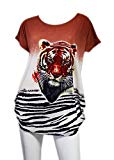

In [0]:
display(Image(url=data.iloc[12566].medium_image_url, embed=True))

### Recommendations:

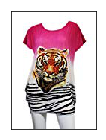

TITLE: pink tiger tshirt zebra stripes xl  xxl 
ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from the given image : 1.7320508075688772


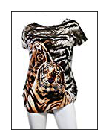

TITLE: brown  white tiger tshirt tiger stripes xl  xxl 
ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from the given image : 2.449489742783178


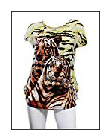

TITLE: yellow tiger tshirt tiger stripes  l 
ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from the given image : 2.6457513110645907


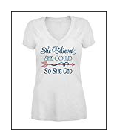

TITLE: believed could tshirt 
ASIN : B07568NZX4
Brand : Rustic Grace
euclidean distance from the given image : 3.0


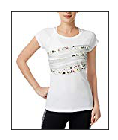

TITLE: ideology graphic tshirt xl white 
ASIN : B01NB0NKRO
Brand : Ideology
euclidean distance from the given image : 3.0


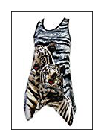

TITLE: grey  white tiger tank top tiger stripes xl  xxl 
ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from the given image : 3.0


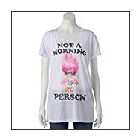

TITLE: morning person tshirt  troll picture  xl 
ASIN : B01CLS8LMW
Brand : Awake
euclidean distance from the given image : 3.1622776601683795


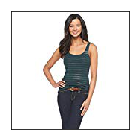

TITLE: merona green gold stripes 
ASIN : B01KVZUB6G
Brand : Merona
euclidean distance from the given image : 3.1622776601683795


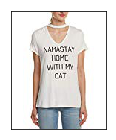

TITLE: blvd womens graphic tshirt l 
ASIN : B0733R2CJK
Brand : BLVD
euclidean distance from the given image : 3.1622776601683795


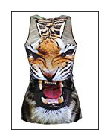

TITLE: km tiger printed sleeveless vest tshirt 
ASIN : B012VQLT6Y
Brand : KM T-shirt
euclidean distance from the given image : 3.1622776601683795


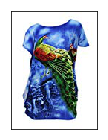

TITLE: blue peacock print tshirt  l 
ASIN : B00JXQC8L6
Brand : Si Row
euclidean distance from the given image : 3.1622776601683795


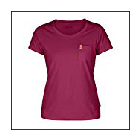

TITLE: fjallraven  womens ovik tshirt plum xxl 
ASIN : B06XC3CZF6
Brand : Fjallraven
euclidean distance from the given image : 3.1622776601683795


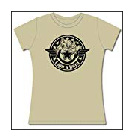

TITLE: hetalia us girl tshirt 
ASIN : B005IT8OBA
Brand : Hetalia
euclidean distance from the given image : 3.1622776601683795


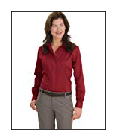

TITLE: canvas 3001 30s tshirt  kelly  xl 
ASIN : B0088PN0LA
Brand : Red House
euclidean distance from the given image : 3.1622776601683795


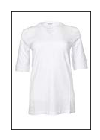

TITLE: brunello cucinelli tshirt women white xl 
ASIN : B06X99V6WC
Brand : Brunello Cucinelli
euclidean distance from the given image : 3.1622776601683795


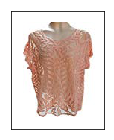

TITLE: xhilaration womens lace tshirt salmon xxl 
ASIN : B06Y1JPW1Q
Brand : Xhilaration
euclidean distance from the given image : 3.1622776601683795


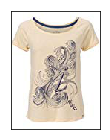

TITLE: animal oceania tshirt  yellow 
ASIN : B06X6GX6WG
Brand : Animal
euclidean distance from the given image : 3.1622776601683795


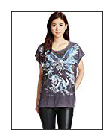

TITLE: diesel tserraf tshirt black 
ASIN : B017X8PW9U
Brand : Diesel
euclidean distance from the given image : 3.1622776601683795


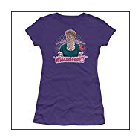

TITLE: juniors love lucywaaaaahhhh tshirt size xl 
ASIN : B00IAA4JIQ
Brand : I Love Lucy
euclidean distance from the given image : 3.1622776601683795


In [0]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo
import PIL.Image
def title_brand_colour_image_weighted(doc_id, w1, w2, w3,num_results):
    idf_w2v_dist  = pairwise_distances(idf_title_features,idf_title_features[doc_id])
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    image_feat_dist=pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist+w3*image_feat_dist)/float(w1 + w2+w3)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(1,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('TITLE:',data['title'].loc[df_indices[i]])
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

title_brand_colour_image_weighted(12566, 10, 2,5, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

## Observation(s):

1. This recommendation system is based on the item - item similarity.
2. Item -item similarity has been calculated using Euclidian distance.
3. The matrix of euclidian distance for this problem has been calculated using a weighted average of IDF encoding of 'title',One hot encoding of 'Colour and Brand' and CNN based encoding of images.